# Day 2: Model Drift Investigation

This notebook creates a plot showing model drift in the same six panel fornat as explained in 00_DCPP_GPCC_visualisation.ipynb.

Step 1: The overall mean is calculated for all DCPP forecasts initialised from 1960 to 2015.  
Step 2: The lead time mean is calculated for each DCPP model.  
Step 3: Difference is taken between lead time mean and overall mean and finally plotted.


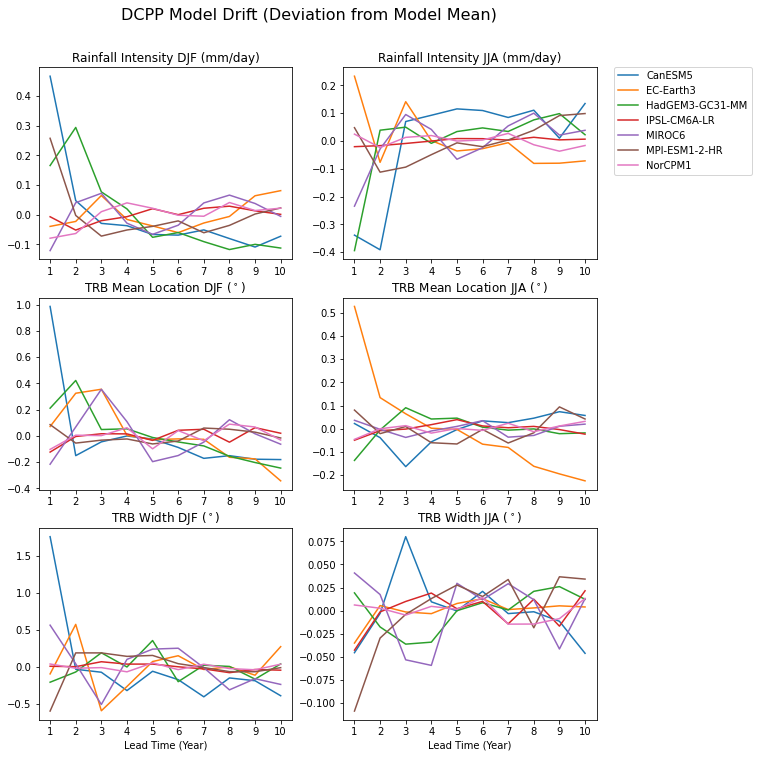

In [29]:
import numpy as np
import xarray as xr
import glob as glob
import matplotlib.pyplot as plt

model_namelist = ['CanESM5', 'EC-Earth3', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'NorCPM1']
dcpp_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/DCPP/TRBindices'
gpcc_trbindices_directory = '/gws/pw/j05/cop26_hackathons/bristol/project02/data/obs/TRBindices/GPCC'
gpcc_obs = xr.open_dataset(gpcc_trbindices_directory+'/pr_1m_zonAvgNikulin_GPCC_1891-2019_05.nc')

fig, axs = plt.subplots(3, 2, figsize=(10,12))
lead_time_years = np.arange(1,11,1)

for model_name in model_namelist:

    model_filelist = glob.glob(dcpp_trbindices_directory+'/'+model_name+'/*.nc')
    model_filelist.sort()

    model_ensembles_all_djf = list()
    model_ensembles_all_jja = list()
    for model_file in model_filelist:
        model_dataset = xr.open_dataset(model_file)


        # Selection conditions
        is_djf = (model_dataset['time'].dt.season == 'DJF')
        is_jja = (model_dataset['time'].dt.season == 'JJA')


        model_ensemble_mean = model_dataset.gaussian_params.mean(dim='ensemble')
        model_ensemble_mean_djf = model_ensemble_mean.isel(time=is_djf)
        model_ensemble_mean_djf = model_ensemble_mean_djf.groupby('time.year').mean('time')
        model_ensembles_all_djf.append(model_ensemble_mean_djf)

        model_ensemble_mean_jja = model_ensemble_mean.isel(time=is_jja)
        model_ensemble_mean_jja = model_ensemble_mean_jja.groupby('time.year').mean('time')
        model_ensembles_all_jja.append(model_ensemble_mean_jja)

    # Step 1
    overall_param_means_djf = np.mean(np.mean(np.array(model_ensembles_all_djf), axis=1), axis=0)
    overall_param_means_jja = np.mean(np.mean(np.array(model_ensembles_all_jja), axis=1), axis=0)

    # Step 2
    lead_time_means_djf = np.mean(np.array(model_ensembles_all_djf), axis=0)
    lead_time_means_jja = np.mean(np.array(model_ensembles_all_jja), axis=0)

    # Step 3
    difference_djf = lead_time_means_djf - overall_param_means_djf
    difference_jja = lead_time_means_jja - overall_param_means_jja
    
    axs[0,0].plot(lead_time_years, difference_djf[:,0], label=model_name)
    axs[1,0].plot(lead_time_years, difference_djf[:,1], label=model_name)
    axs[2,0].plot(lead_time_years, difference_djf[:,2], label=model_name)
    axs[0,1].plot(lead_time_years, difference_jja[:,0], label=model_name)
    axs[1,1].plot(lead_time_years, difference_jja[:,1], label=model_name)
    axs[2,1].plot(lead_time_years, difference_jja[:,2], label=model_name)

axs[0,1].legend(bbox_to_anchor=(1.05, 1.03), loc='upper left')
axs[0,0].set_title('Rainfall Intensity DJF (mm/day)')
axs[0,0].set_xticks(lead_time_years)
axs[1,0].set_title(r'TRB Mean Location DJF ($^\circ$)')
axs[1,0].set_xticks(lead_time_years)
axs[2,0].set_title(r'TRB Width DJF ($^\circ$)')
axs[2,0].set_xticks(lead_time_years)
axs[2,0].set_xlabel('Lead Time (Year)')
axs[0,1].set_title('Rainfall Intensity JJA (mm/day)')
axs[0,1].set_xticks(lead_time_years)
axs[1,1].set_title(r'TRB Mean Location JJA ($^\circ$)')
axs[1,1].set_xticks(lead_time_years)
axs[2,1].set_title(r'TRB Width JJA ($^\circ$)')
axs[2,1].set_xlabel('Lead Time (Year)')
axs[2,1].set_xticks(lead_time_years)

fig.suptitle(f'DCPP Model Drift (Deviation from Model Mean)', fontsize=16, y=0.95)

plt.show()
# plt.savefig('subgroup3_day2_hockeystick.pdf', bbox_inches='tight')